In [1]:
#Importing the libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [2]:
#Importing the data
data = pd.read_csv('Sentiment.csv')

In [3]:
data.head() #printing first five rows

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [4]:
# Keeping only the neccessary columns
data = data[['text','sentiment']]

In [5]:
data.sentiment.value_counts() #printing the value counts

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

Positive words


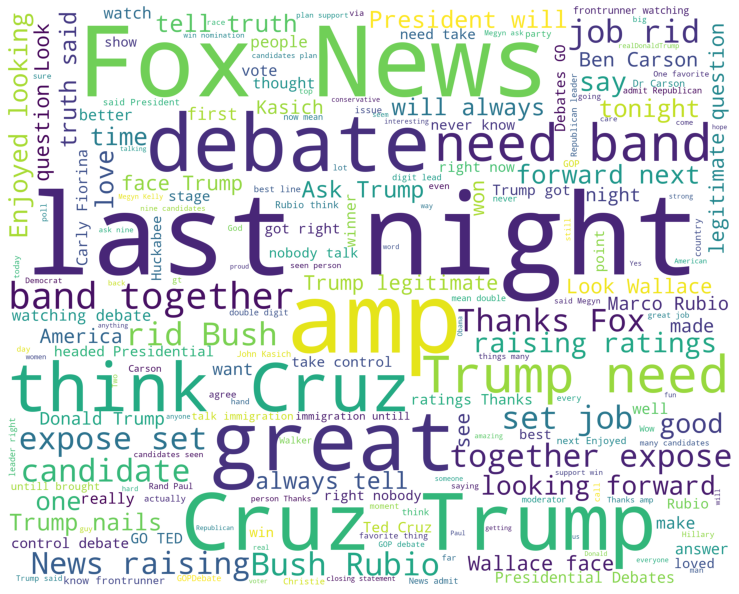

Negative words


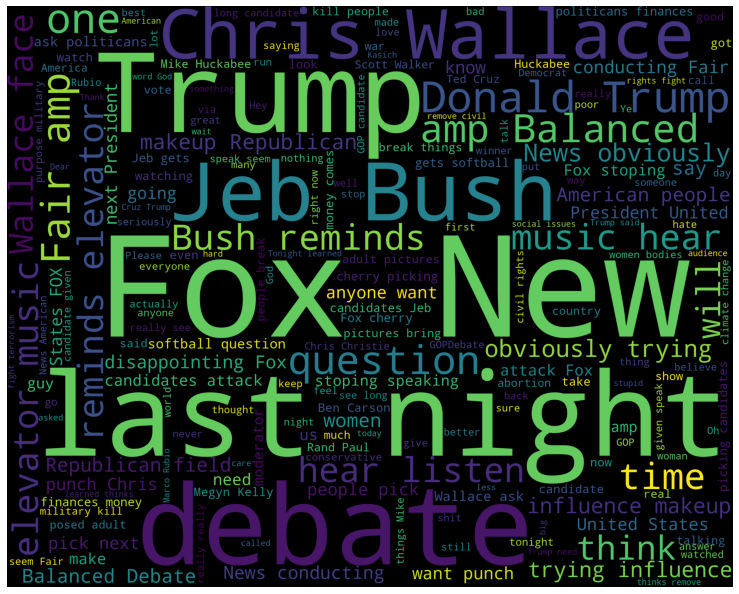

In [6]:
#wordcloud

train_pos = data[data['sentiment'] == 'Positive'] #train_pos contains only positive data
train_pos = train_pos['text'] 
train_neg = data[data['sentiment'] == 'Negative'] #train_neg conatins only negative data
train_neg = train_neg['text']

#creating a wordcloud_plot function for printing the key words in both positive and negative sentiment
def wordcloud_plot(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() #splitting the text into words
                            if 'http' not in word
                                and not word.startswith('@') #getting the words not starting with @
                                and not word.startswith('#') #getting the words not starting with #
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13)) #displaying the figure of wordcount
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

    
print("Positive words")
wordcloud_plot(train_pos,'white')  #Printing the wordcloud plot for positive words
print("Negative words")
wordcloud_plot(train_neg) #pritnting the wordcloud plot for negative words

In [7]:
#pre-processing the text data
data['text'] = data['text'].apply(lambda x: x.lower()) #lowers all the characters
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x))) #removes special characters

In [8]:
#iterating all the rows for removing any retweet tag
for idx, row in data.iterrows():
    row[0] = row[0].replace('rt', ' ')

In [9]:
#Tokenization
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ') #splitting the texts into tokens
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values) #converting the texts to sequences

In [10]:
X = pad_sequences(X) #padding the sequences

In [11]:
embed_dim = 128
lstm_out = 196
def createmodel():  #createmodel 
    model = Sequential() 
    model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1])) #passing parameters
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)) #adding one more layer with LSTM
    model.add(Dense(3,activation='softmax')) #output layer
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

In [12]:
labelencoder = LabelEncoder() #labelENcoder
integer_encoded = labelencoder.fit_transform(data['sentiment']) #fitting the data to the labelencoder
y = to_categorical(integer_encoded) 
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, random_state = 42) #splitting the data into train and test

In [13]:
#printting the shapes of train and test data
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9293, 28) (9293, 3)
(4578, 28) (4578, 3)


In [15]:
#GridsearchCV
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=createmodel, verbose=0)
batch_size= [10, 20, 40]
epochs = [1, 2, 3]
param_grid= dict(batch_size=batch_size, epochs=epochs)


grid  = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result= grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.680833 using {'batch_size': 20, 'epochs': 2}


In [18]:
batch_size = 20
model = createmodel()
model.fit(X_train, Y_train, epochs = 2, batch_size=batch_size, verbose = 2) #fitting the model.
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size) #finding accuracy and loss of model.
print('score of the model is    : ' ,score)
print('Accuracy of the model is : ' ,acc)
print(model.metrics_names)

Epoch 1/2
465/465 - 39s - loss: 0.8151 - accuracy: 0.6468
Epoch 2/2
465/465 - 41s - loss: 0.6744 - accuracy: 0.7148
229/229 - 6s - loss: 0.7402 - accuracy: 0.6859
score of the model is    :  0.7401608824729919
Accuracy of the model is :  0.6858890056610107
['loss', 'accuracy']


#### Observations :
1. Score of the model is    : 74%
2. Accuracy of the model is : 68%